# sMRI Statistical Analysis

---

Questions:

* How to quantify brain morphology ?
* How to assess statistically differences of brain morphology ?
* Can we detect brain changes related to age in a cohort of young adults ?

Objectives:

* Understand the main metrics characterizing the brain morphology
* Extract and rely on a set of metrics to assess the effect of age on multiple cortical regions
* Understand and implement voxel based morphometry to investigate the effect of age without predefined regions

## Quantifying tissue properties

Brain structural data can be represented as volumes or surfaces. Each of these representations are associated to different characteristics. In this episode we will look at:

* how to measure GM volume when looking at volumetric data, i.e. voxels
* how to extract cortical thickness measures derived from surface data, i.e. meshes

### Metric from volumetric data: region volumes

A simple metric to quantify brain imaging data is volume. The image is represented as voxels, however the voxel dimensions can vary from one MRI sequence to another. Some FLAIR sequences have 1.5 mm isotropic voxels (i.e. 1.5 mm wide in all directions), while T1 sequences have 1 mm isotropic voxels. Other sequences do not have isotropic voxels (the voxel dimensions vary depending on direction). As a result the number of voxels is not useful to compare subjects and a standard unit such that $mm^3$ or $cm^3$ should be used instead.

We will consider here a volumetric atlas created by `smriprep/fmriprep` via `Freesurfer`. A particularity is that this atlas is mapped to the subject native space so that we can measure the volume of each atlas ROI in the space of the subject. Our aim is to measure the volume of the right caudate nucleus (尾状核), in standard unit ($mm^3$). We will first see how to obtain the volume manually, and then how to simply retrieve it from a file referencing several region volumes.

We will use [AOMIC](https://nilab-uva.github.io/AOMIC.github.io/) dataset.


In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
from nilearn import plotting
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib

%matplotlib inline

from bids import BIDSLayout

data_dir = 'local_data/AOMIC/'
fmriprep_dir = 'local_data/AOMIC/derivatives/fmriprep/'
fsstats_dir = 'local_data/AOMIC/derivatives/fs_stats/'
vbm_dir = 'local_data/AOMIC/derivatives/vbm/'

bids_layout = BIDSLayout(data_dir, derivatives=True)
bids_layout

C:\Language\Miniconda3\lib\site-packages\nilearn\datasets\__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
C:\Language\Miniconda3\lib\site-packages\bids\layout\validation.py:149: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


BIDS Layout: ...n-Python\sMRI\local_data\AOMIC | Subjects: 2 | Sessions: 0 | Runs: 0

#### Measuring an ROI volume manually

Consider a subject’s native T1 volume `t1` and a parcellation of the subcortical GM provided by Freesurfer in that space, `t1_aseg`. We already know from episode 4 how to extract an ROI. According to the [Freesurfer Look-up Table](https://surfer.nmr.mgh.harvard.edu/fswiki/FsTutorial/AnatomicalROI/FreeSurferColorLUT) the right caudate has index 50.

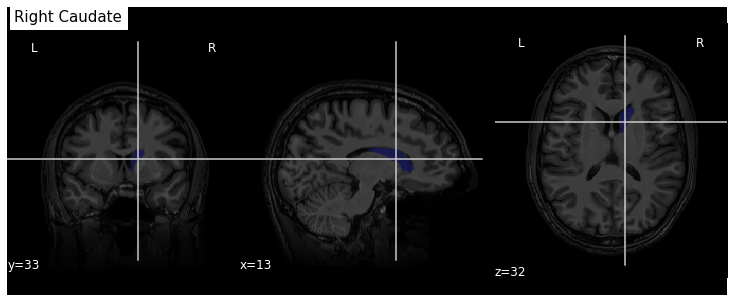

In [2]:
t1_file = bids_layout.get(subject="0001",
                          scope="derivatives",
                          datatype='anat',
                          desc='preproc',
                          extension='nii.gz',
                          return_type='filename')[0]
t1 = nib.load(t1_file)

t1_aseg_file = bids_layout.get(subject="0001",
                               scope="derivatives",
                               datatype='anat',
                               suffix='dseg',
                               desc="aseg",
                               extension='nii.gz',
                               return_type='filename')[0]
t1_aseg = nib.load(t1_aseg_file)

roi_ix = 50
roi_mask_arr_bool = (t1_aseg.get_fdata() == roi_ix)
roi_mask_arr = roi_mask_arr_bool.astype(int)
roi_mask = nib.Nifti1Image(roi_mask_arr, affine=t1_aseg.affine)

fig = plt.figure(figsize=(10, 4))
plotting.plot_roi(roi_img=roi_mask, bg_img=t1, alpha=0.4, title='Right Caudate', figure=fig)

We can get the number of voxels by counting them in the mask:

In [3]:
caudate_R_n_vox = roi_mask_arr.sum()
caudate_R_n_vox

3854

An image voxel size can be obtained from the file metadata (i.e. data annotation) stored in the image header. `nibabel` provide an header attribute with a method `get_zooms()` to obtain the voxel size.

In [4]:
voxel_dimensions = t1.header.get_zooms()
voxel_dimensions

(1.0, 1.0, 1.0)

In our case the volume of the voxel, the product of its dimensions, is simply $1 mm^3$:

In [6]:
vox_size = np.array(voxel_dimensions).prod()
vox_size

caudate_R_vol_mm3 = caudate_R_n_vox * vox_size
caudate_R_vol_mm3

3854.0

Note that nibabel offers a utility function to compute the volume of a mask in $mm^3$ according to the voxel size:

In [7]:
import nibabel.imagestats as imagestats
imagestats.mask_volume(roi_mask)

3854.0

#### Extracting ROI volume from software generated reports

It turns out that characteristics of a number of ROIs are output by Freesurfer and saved in a text file. For example the volume of subcortical ROIs can be found in the file stats/aseg.stats. We use the function islice of the Python itertools module to extract the first lines of the file:

In [8]:
fs_rawstats_dir = "local_data/AOMIC/derivatives/freesurfer/sub-0001/stats/"

from itertools import islice

n_lines = 110
with open(fs_rawstats_dir + "aseg.stats") as fs_stats_file:
    first_n_lines = list(islice(fs_stats_file, n_lines))

first_n_lines

['# Title Segmentation Statistics \n',
 '# \n',
 '# generating_program mri_segstats\n',
 '# cvs_version $Id: mri_segstats.c,v 1.121 2016/05/31 17:27:11 greve Exp $\n',
 '# cmdline mri_segstats --seg mri/aseg.mgz --sum stats/aseg.stats --pv mri/norm.mgz --empty --brainmask mri/brainmask.mgz --brain-vol-from-seg --excludeid 0 --excl-ctxgmwm --supratent --subcortgray --in mri/norm.mgz --in-intensity-name norm --in-intensity-units MR --etiv --surf-wm-vol --surf-ctx-vol --totalgray --euler --ctab /opt/freesurfer/ASegStatsLUT.txt --subject sub-0001 \n',
 '# sysname  Linux\n',
 '# hostname d8c6a608d514\n',
 '# machine  x86_64\n',
 '# user     root\n',
 '# anatomy_type volume\n',
 '# \n',
 '# SUBJECTS_DIR /out/freesurfer\n',
 '# subjectname sub-0001\n',
 '# Measure BrainSeg, BrainSegVol, Brain Segmentation Volume, 1248820.000000, mm^3\n',
 '# Measure BrainSegNotVent, BrainSegVolNotVent, Brain Segmentation Volume Without Ventricles, 1235952.000000, mm^3\n',
 '# Measure BrainSegNotVentSurf, Brai

Surprisingly the volume in $mm^3$ is not the same as we found: 3804.7. This is because instead of counting each voxel in the GM mask as 100%, the fraction of estimated GM was taken into account. The estimation of the so called “partial volume” can be done in several manners. One which will be useful for us later is to use the GM probability map `GM_probmap` as a surrogate of a GM partial volume map.

The difference in volume is probably from the fact that Freesurfer takes into account the proportion of GM in each voxel. This can be done "geometrically" by looking at the fraction of the voxel inside the GM surface, or by interpreting the probability of GM presence as the GM partial volume. Let’s see the ROI volume we obtain in this way:

In [9]:
GM_probmap_file = bids_layout.get(subject="0001",
                                  scope="derivatives",
                                  datatype='anat',
                                  label="GM",
                                  suffix="probseg",
                                  extension='nii.gz',
                                  return_type='filename')[0]
GM_probmap = nib.load(GM_probmap_file)

GM_roi_data = np.where(roi_mask_arr_bool, GM_probmap.get_fdata(), 0)
GM_roi_data.sum() * vox_size

3354.5343634674136

### Metric from surface data with Freesurfer: cortical thickness

As seen in the previous section, volumetric ROI metrics can be made available by dedicated software. This is also the case for surface metrics which are often more involved than computing the number of voxels. One of the most used surface metric is cortical thickness: the distance separating the GM pial surface from the WM surface directly underneath. We will use the output from Freesurfer to:

* extract cortical thickness information
* plot the associated surface data for one subject
* generate and plot summary group measurements

Freesurfer output by default several files to quantify both volume and surface data of each subject. After processing with `smriprep/fmriprep`, these files can be found in `derivatives/freesurfer/stats`.

In [10]:
os.listdir(fs_rawstats_dir)

['aseg.stats',
 'lh.aparc.a2009s.stats',
 'lh.aparc.DKTatlas.stats',
 'lh.aparc.pial.stats',
 'lh.aparc.stats',
 'lh.BA_exvivo.stats',
 'lh.BA_exvivo.thresh.stats',
 'lh.curv.stats',
 'lh.w-g.pct.stats',
 'rh.aparc.a2009s.stats',
 'rh.aparc.DKTatlas.stats',
 'rh.aparc.pial.stats',
 'rh.aparc.stats',
 'rh.BA_exvivo.stats',
 'rh.BA_exvivo.thresh.stats',
 'rh.curv.stats',
 'rh.w-g.pct.stats',
 'wmparc.stats']

`aseg` is for subcortical volumetric regions ("segmentation" in Freesurfer-speak) and `aparc` for cortical surface regions ("parcellation" in Freesurfer-speak). `aparc.stats` is for the Desikan-Killiany atlas while `aparc.a2009s.stats` is for the Destrieux atlas (more regions).

### Extracting cortical thickness information

Freesurfer output a number of files including both volume and surface metrics. These files are generated by Freesurfer for each subject and can be found in `derivatives/freesurfer/stats` when using `smriprep/fmriprep`.

Looking at the Destrieux ROI measurements in the left hemisphere from `lh.aparc.a2009s.stats` we get:

In [12]:
n_lines = 75
with open(fs_rawstats_dir + "lh.aparc.a2009s.stats") as fs_stats_file:
    first_n_lines = list(islice(fs_stats_file, n_lines))

first_n_lines

['# Table of FreeSurfer cortical parcellation anatomical statistics \n',
 '# \n',
 '# CreationTime 2019/03/02-22:05:09-GMT\n',
 '# generating_program mris_anatomical_stats\n',
 '# cvs_version $Id: mris_anatomical_stats.c,v 1.79 2016/03/14 15:15:34 greve Exp $\n',
 '# mrisurf.c-cvs_version $Id: mrisurf.c,v 1.781.2.6 2016/12/27 16:47:14 zkaufman Exp $\n',
 '# cmdline mris_anatomical_stats -th3 -mgz -cortex ../label/lh.cortex.label -f ../stats/lh.aparc.a2009s.stats -b -a ../label/lh.aparc.a2009s.annot -c ../label/aparc.annot.a2009s.ctab sub-0001 lh white \n',
 '# sysname  Linux\n',
 '# hostname d8c6a608d514\n',
 '# machine  x86_64\n',
 '# user     root\n',
 '# \n',
 '# SUBJECTS_DIR /out/freesurfer\n',
 '# anatomy_type surface\n',
 '# subjectname sub-0001\n',
 '# hemi lh\n',
 '# AnnotationFile ../label/lh.aparc.a2009s.annot\n',
 '# AnnotationFileTimeStamp 2019/03/02 22:05:03\n',
 '# Measure Cortex, NumVert, Number of Vertices, 134288, unitless\n',
 '# Measure Cortex, WhiteSurfArea, White S

You can see a number of metrics, with more information in the skipped header on their units. The one of particular interest to us is the cortical thickness `ThickAvg`. Since the thickness is measured at each vertex of the mesh, both the man and standard deviation can be estimated for each ROI. The values at each vertex is available in the freesurfer native file `lh.thickness`. Let’s use it to plot the values on a mesh.

### Plotting cortical thickness values on a subject meshes

To plot the cortical thickness values on a subject cortical mesh we will use the native Freesurfer file formats (although the GII file output by `smriprep/fmriprep` could also be used as seen in episode 4). Considering we identified for the left hemispher the path to the pial mesh `lh_pial` and the mesh thickness values `lh_thickness` (as well as the sulcus mesh `lh_sulcus` for a better plot rendering), we can obtain mesh lateral and medial views with the following Python code:

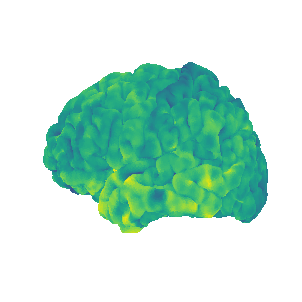

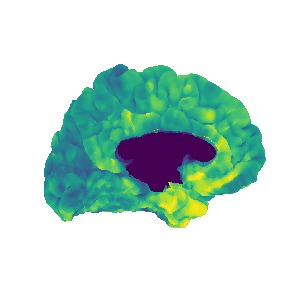

In [15]:
fs_surf_dir = "local_data/AOMIC/derivatives/freesurfer/sub-0001/surf/"
lh_sulcus = fs_surf_dir + "lh.sulc"
lh_pial = fs_surf_dir + "lh.pial"
lh_thickness = fs_surf_dir + "lh.thickness"

# Lateral
plotting.plot_surf(lh_pial,
                   surf_map=lh_thickness,
                   hemi='left',
                   view='lateral',
                   bg_map=lh_sulcus);
# Medial
plotting.plot_surf(lh_pial,
                   surf_map=lh_thickness,
                   hemi='left',
                   view='medial',
                   bg_map=lh_sulcus);

### Generating and plotting summary group measurements

Files including metrics for each subject can be leveraged to generate group results automatically. The first step is to generate more easily manipulatable CSV/TSV files from the Freesurfer native text files. This can be done with the Freesurfer `asegstats2table` command such as with the code below adapted from this [script](https://github.com/NILAB-UvA/AOMIC-common-scripts/blob/master/fs_stats/create_freesurfer_tables.sh):

```
SUBJECTS=(...)
MEASURE=thickness
PARC=aparc.a2009s
for HEMI in lh rh; do
    echo "Running aparcstats2table with measure ${MEASURE} and parcellation ${parc} for hemisphere ${HEMI}"
    aparcstats2table --subjects ${SUBJECTS[@]} \
        --hemi ${hemi} \
        --parc ${parc} \
        --measure ${MEASURE} \
        --tablefile ../derivatives/fs_stats/data-cortical_type-${parc}_measure-${MEASURE}_hemi-${HEMI}.tsv \
        --delimiter 'tab'
done
```

Then the resulting files can be read with pandas to create a dataframe including cortical thickness information for all our subjects.

In [17]:
fs_stats_dir = "local_data/AOMIC/derivatives/fs_stats"
hemi="lh"
stats_file = os.path.join(fs_stats_dir,
                          f"data-cortical_type-aparc.a2009s_measure-thickness_hemi-{hemi}.tsv")

fs_hemi_df = pd.read_csv(stats_file, sep='\t')
fs_hemi_df.head()

,lh.aparc.a2009s.thickness,lh_G&S_frontomargin_thickness,lh_G&S_occipital_inf_thickness,lh_G&S_paracentral_thickness,lh_G&S_subcentral_thickness,lh_G&S_transv_frontopol_thickness,lh_G&S_cingul-Ant_thickness,lh_G&S_cingul-Mid-Ant_thickness,lh_G&S_cingul-Mid-Post_thickness,lh_G_cingul-Post-dorsal_thickness,...,lh_S_precentral-inf-part_thickness,lh_S_precentral-sup-part_thickness,lh_S_suborbital_thickness,lh_S_subparietal_thickness,lh_S_temporal_inf_thickness,lh_S_temporal_sup_thickness,lh_S_temporal_transverse_thickness,lh_MeanThickness_thickness,BrainSegVolNotVent,eTIV
0,sub-0001,1.925,2.517,2.266,2.636,2.600,2.777,2.606,2.736,2.956,...,2.719,2.302,2.417,2.514,2.485,2.462,2.752,2.56319,1235952.0,1.560839e+06
1,sub-0002,2.405,2.340,2.400,2.849,2.724,2.888,2.658,2.493,3.202,...,2.248,2.342,3.264,2.619,2.212,2.386,2.772,2.45903,1056970.0,1.115228e+06
2,sub-0003,2.477,2.041,2.255,2.648,2.616,2.855,2.924,2.632,2.984,...,2.489,2.276,2.130,2.463,2.519,2.456,2.685,2.53883,945765.0,1.186697e+06
3,sub-0004,2.179,2.137,2.366,2.885,2.736,2.968,2.576,2.593,3.211,...,2.399,2.145,2.920,2.790,2.304,2.564,2.771,2.51093,973916.0,9.527770e+05
4,sub-0005,2.483,2.438,2.219,2.832,2.686,3.397,2.985,2.585,3.028,...,2.569,2.352,3.598,2.331,2.494,2.665,2.538,2.53830,1089881.0,1.497743e+06


Collect data for the Destrieux atlas for left and right hemisphere:

In [18]:
fs_df = pd.DataFrame()
for hemi in ['lh','rh']:
    stats_file = os.path.join(fs_stats_dir,
                              f"data-cortical_type-aparc.a2009s_measure-thickness_hemi-{hemi}.tsv")
    fs_hemi_df = pd.read_csv(stats_file,sep='\t')
    # Rename columns to concat multiple cohorts / hemis and remove verbose freesurfer suffixes
    orig_cols = list(fs_hemi_df.columns)
    roi_and_mean_cols = []
    for col in orig_cols[1:-2]:
        roi_name_with_special_chars = col.split('_',1)[1].rsplit('_',1)[0]
        roi_name = roi_name_with_special_chars.replace('&', '_and_').replace('-', '_')
        roi_and_mean_cols.append(roi_name)
    renamed_cols = ['participant_id'] + roi_and_mean_cols
    old2new_roinames = dict(zip(orig_cols, renamed_cols))
    new2old_roinames = dict(zip(renamed_cols, orig_cols))
    fs_hemi_df = fs_hemi_df.rename(columns=old2new_roinames)
    fs_hemi_df['hemi'] = hemi
    fs_df = fs_df.append(fs_hemi_df)
    roi_cols = roi_and_mean_cols[:-1]
    print(f"Hemisphere: {hemi}, Number of ROIs: {len(roi_cols)}")
fs_df.head()

Hemisphere: lh, Number of ROIs: 74
Hemisphere: rh, Number of ROIs: 74


,participant_id,G_and_S_frontomargin,G_and_S_occipital_inf,G_and_S_paracentral,G_and_S_subcentral,G_and_S_transv_frontopol,G_and_S_cingul_Ant,G_and_S_cingul_Mid_Ant,G_and_S_cingul_Mid_Post,G_cingul_Post_dorsal,...,S_precentral_sup_part,S_suborbital,S_subparietal,S_temporal_inf,S_temporal_sup,S_temporal_transverse,MeanThickness,BrainSegVolNotVent,eTIV,hemi
0,sub-0001,1.925,2.517,2.266,2.636,2.600,2.777,2.606,2.736,2.956,...,2.302,2.417,2.514,2.485,2.462,2.752,2.56319,1235952.0,1.560839e+06,lh
1,sub-0002,2.405,2.340,2.400,2.849,2.724,2.888,2.658,2.493,3.202,...,2.342,3.264,2.619,2.212,2.386,2.772,2.45903,1056970.0,1.115228e+06,lh
2,sub-0003,2.477,2.041,2.255,2.648,2.616,2.855,2.924,2.632,2.984,...,2.276,2.130,2.463,2.519,2.456,2.685,2.53883,945765.0,1.186697e+06,lh
3,sub-0004,2.179,2.137,2.366,2.885,2.736,2.968,2.576,2.593,3.211,...,2.145,2.920,2.790,2.304,2.564,2.771,2.51093,973916.0,9.527770e+05,lh
4,sub-0005,2.483,2.438,2.219,2.832,2.686,3.397,2.985,2.585,3.028,...,2.352,3.598,2.331,2.494,2.665,2.538,2.53830,1089881.0,1.497743e+06,lh


### Plotting distribution of cortical thickness among all subjects

As shown in the notebook associated with the lesson we can then create a dataframe `fs_df` combining both data from both hemispheres, while also renaming columns to facilitate subsequent analysis.

We can then create a boxplot of the mean cortical thickness distribution in each ROI with seaborn, after first converting the dataframe from wide to long format:

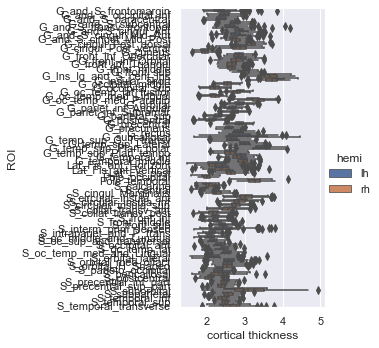

In [21]:
plot_df = fs_df[["hemi"] + roi_cols]
## Melt dataframe for easier visualization
plot_long_df = pd.melt(plot_df,
                       id_vars = ['hemi'],
                       value_vars = roi_cols,
                       var_name ='ROI',
                       value_name ='cortical thickness')

sns.set(rc={'figure.figsize':(15, 8)})
g = sns.catplot(x='cortical thickness', y='ROI', hue='hemi', kind='box', data=plot_long_df)


## Statistical analysis: cortical thickness analysis based on a surface atlas

Can we measure cortical thickness changes with age in young adults ?

Now that we have cortical thickness measures, we can try to answer this question by:

* adding subject demographic variables (age, sex) which will serve as predictors
* creating and fitting a statistical model: we will use linear regression model
* plotting the results

### Gathering the model predictors

Since we are interested in the effect of age, we will collect the subject demographics information which is readily available from the BIDS dataset. In addition of the age information, we will use sex as a covariate.





In [22]:
subjects_info_withna = bids_layout.get(suffix="participants", extension=".tsv")[0].get_df()
subjects_info_withna

,participant_id,age,sex,BMI,handedness,education_category,raven_score,NEO_N,NEO_E,NEO_O,NEO_A,NEO_C
0,sub-0001,25.50,M,21.0,right,academic,33.0,23,40,52,47,32
1,sub-0002,23.25,F,22.0,right,academic,19.0,22,47,34,53,46
2,sub-0003,25.00,F,23.0,right,applied,29.0,26,42,37,48,48
3,sub-0004,20.00,F,18.0,right,academic,24.0,32,42,36,48,52
4,sub-0005,24.75,M,27.0,right,academic,24.0,32,51,41,51,53
...,...,...,...,...,...,...,...,...,...,...,...,...
221,sub-0222,22.00,F,20.0,right,academic,30.0,41,35,51,48,42
222,sub-0223,20.75,F,23.0,left,applied,26.0,33,41,54,36,41
223,sub-0224,21.75,M,20.0,right,academic,34.0,22,45,47,46,46
224,sub-0225,20.25,F,28.0,right,academic,27.0,48,32,43,42,37


#### Data cleaning


In [38]:
subjects_info_withna = bids_layout.get(suffix="participants", extension=".tsv")[0].get_df()
subjects_info = subjects_info_withna.copy()
subjects_info["age"] = subjects_info_withna["age"].fillna(subjects_info_withna["age"].mean())
subjects_info["sex"] = subjects_info_withna["sex"].fillna(subjects_info_withna["sex"].mode()[0])
subjects_info.loc[subjects_info.isnull().any(axis=1), :]

subjects_info = subjects_info_withna
demo_cols = ["participant_id", "age", "sex"]
fs_all_df = pd.merge(subjects_info[demo_cols], fs_df, on='participant_id')
fs_all_df

,participant_id,age,sex,G_and_S_frontomargin,G_and_S_occipital_inf,G_and_S_paracentral,G_and_S_subcentral,G_and_S_transv_frontopol,G_and_S_cingul_Ant,G_and_S_cingul_Mid_Ant,...,S_precentral_sup_part,S_suborbital,S_subparietal,S_temporal_inf,S_temporal_sup,S_temporal_transverse,MeanThickness,BrainSegVolNotVent,eTIV,hemi
0,sub-0001,25.50,M,1.925,2.517,2.266,2.636,2.600,2.777,2.606,...,2.302,2.417,2.514,2.485,2.462,2.752,2.56319,1235952.0,1.560839e+06,lh
1,sub-0001,25.50,M,2.216,2.408,2.381,2.698,2.530,2.947,2.896,...,2.324,2.273,2.588,2.548,2.465,2.675,2.51412,1235952.0,1.560839e+06,rh
2,sub-0002,23.25,F,2.405,2.340,2.400,2.849,2.724,2.888,2.658,...,2.342,3.264,2.619,2.212,2.386,2.772,2.45903,1056970.0,1.115228e+06,lh
3,sub-0002,23.25,F,2.682,2.454,2.511,2.725,2.874,3.202,3.012,...,2.429,2.664,2.676,2.220,2.291,2.714,2.48075,1056970.0,1.115228e+06,rh
4,sub-0003,25.00,F,2.477,2.041,2.255,2.648,2.616,2.855,2.924,...,2.276,2.130,2.463,2.519,2.456,2.685,2.53883,945765.0,1.186697e+06,lh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,sub-0224,21.75,M,2.076,2.653,2.098,2.307,2.463,2.735,2.602,...,2.136,3.253,2.495,2.309,2.562,2.418,2.41761,1140289.0,1.302062e+06,rh
448,sub-0225,20.25,F,2.513,2.495,2.141,2.492,2.757,2.553,2.238,...,2.304,2.870,2.275,2.481,2.533,2.009,2.43156,1080245.0,1.395822e+06,lh
449,sub-0225,20.25,F,3.061,2.164,2.097,2.462,2.753,3.134,2.786,...,2.174,3.429,2.385,2.378,2.303,2.105,2.41200,1080245.0,1.395822e+06,rh
450,sub-0226,20.00,M,3.010,2.189,2.562,3.142,4.072,3.051,2.292,...,2.375,2.812,2.756,2.524,2.617,2.495,2.62877,1257771.0,1.583713e+06,lh


We can plot the cortical thickness data as a function of age for a single ROI to have an idea of what we may find when applying our model on all ROIs. Let’s look for example at the anterior mid-cingulate cortex (`G_and_S_cingul_Mid_Ant`).

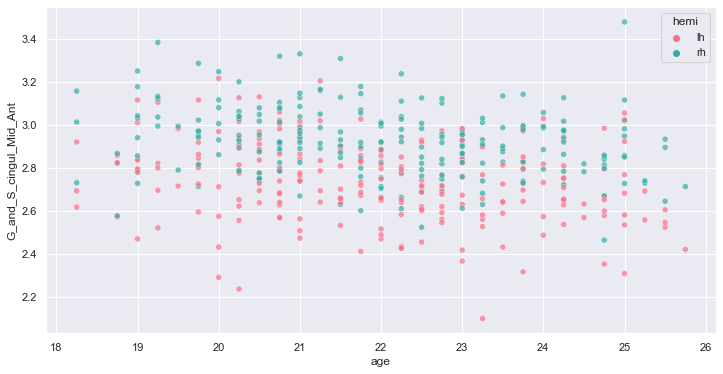

In [39]:
response = 'G_and_S_cingul_Mid_Ant'
predictor = 'age'
plt.figure(figsize=(12, 6))
g = sns.scatterplot(x=predictor,
                    y=response,
                    hue='hemi',
                    alpha=0.7,
                    palette=sns.color_palette('husl',2),
                    data=fs_all_df)

Interesting ! Let’s investigate more formally a potential association of cortical thickness with age in young adults.

### Creating and fitting a statistical model

We will implement an ordinary least square (OLS) regression model. Before applying to all ROIs and correcting for multiple comparison, let’s test it on our previous ROI example.

For this purpose we use the Python `statsmodels` package. We can create a model formula `{response} ~ {predictor} + {covariates}` (similar to R) and passing it as an argument to the ols method before fitting our model. In addition of sex, we will use the total intra-cranial volume (TIV) as covariate.

In [40]:
import statsmodels.formula.api as smf

response = 'G_and_S_cingul_Mid_Ant'
predictor = 'age'
hemi = 'lh'
hemi_df = fs_all_df[fs_all_df['hemi']==hemi]
covariates = 'eTIV + C(sex)'
# Fit regression model
results = smf.ols(f"{response} ~ {predictor} + {covariates}", data=hemi_df).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     G_and_S_cingul_Mid_Ant   R-squared:                       0.062
Model:                                OLS   Adj. R-squared:                  0.049
Method:                     Least Squares   F-statistic:                     4.833
Date:                    Wed, 12 Jan 2022   Prob (F-statistic):            0.00281
Time:                            09:39:10   Log-Likelihood:                 65.237
No. Observations:                     224   AIC:                            -122.5
Df Residuals:                         220   BIC:                            -108.8
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       3.3013      0.181     18.254      0.000       2.945       3.658
C(sex)[T.M]    -0.0014      0.032     -0.043      0.966      -0.065       0.063
age            -0.0260      0.007     -3.784      0.000      -0.040      -0.012
eTIV         6.136e-09   7.49e-08      0.082      0.935   -1.42e-07    1.54e-07
==============================================================================
Omnibus:                        2.512   Durbin-Watson:                   2.113
Prob(Omnibus):                  0.285   Jarque-Bera (JB):                2.140
Skew:                          -0.193   Prob(JB):                        0.343
Kurtosis:                       3.284   Cond. No.                     2.03e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.03e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

To apply the model to all the ROIs, we use the same code as before but within a for loop. Note that a custom function `format_ols_results` has been created to save the results from the previous output in a dataframe.

In [41]:
def format_ols_results(res):
    """ Converts statsmodels summary results (table2)
    into dataframe with minimum useful stat results"""
    results_summary = res.summary()
    results_as_html = results_summary.tables[1].as_html()
    res_df = pd.read_html(results_as_html, header=0, index_col=0)[0].reset_index()
    res_df['R2'] = res.rsquared
    res_df['R2_adj'] = res.rsquared_adj
    return res_df

# OLS result df
ols_df = pd.DataFrame()
predictor = 'age'
covariates = 'eTIV + C(sex)'
for hemi in ['lh','rh']:
    hemi_df = fs_all_df[fs_all_df['hemi']==hemi]
    for response in roi_cols:
        res = smf.ols(f"{response} ~ {predictor} + {covariates}", data=hemi_df).fit()
        res_df = format_ols_results(res)
        res_df['response'] = response
        res_df['hemi'] = hemi
        ols_df = ols_df.append(res_df)
ols_df

,index,coef,std err,t,P>|t|,[0.025,0.975],R2,R2_adj,response,hemi
0,Intercept,2.494200e+00,2.200000e-01,11.335,0.000,2.061000e+00,2.928000e+00,0.004097,-0.009483,G_and_S_frontomargin,lh
1,C(sex)[T.M],-3.300000e-03,3.900000e-02,-0.084,0.933,-8.100000e-02,7.400000e-02,0.004097,-0.009483,G_and_S_frontomargin,lh
2,age,-7.800000e-03,8.000000e-03,-0.934,0.351,-2.400000e-02,9.000000e-03,0.004097,-0.009483,G_and_S_frontomargin,lh
3,eTIV,7.843000e-09,9.120000e-08,0.086,0.932,-1.720000e-07,1.880000e-07,0.004097,-0.009483,G_and_S_frontomargin,lh
0,Intercept,2.607900e+00,1.620000e-01,16.123,0.000,2.289000e+00,2.927000e+00,0.017557,0.004160,G_and_S_occipital_inf,lh
...,...,...,...,...,...,...,...,...,...,...,...
3,eTIV,4.013000e-08,4.790000e-08,0.837,0.403,-5.430000e-08,1.350000e-07,0.079787,0.067239,S_temporal_sup,rh
0,Intercept,3.045700e+00,2.890000e-01,10.552,0.000,2.477000e+00,3.615000e+00,0.040287,0.027200,S_temporal_transverse,rh
1,C(sex)[T.M],-8.570000e-02,5.200000e-02,-1.655,0.099,-1.880000e-01,1.600000e-02,0.040287,0.027200,S_temporal_transverse,rh
2,age,-2.590000e-02,1.100000e-02,-2.366,0.019,-4.800000e-02,-4.000000e-03,0.040287,0.027200,S_temporal_transverse,rh


We correct the results for multiple comparison with Bonferonni correction before plotting.

In [42]:
predictors = ['age']
all_rois_df = ols_df[ols_df['index'].isin(predictors)]
# Multiple comparison correction
n_comparisons = 2 * len(roi_cols) # 2 hemispheres
alpha = 0.05
alpha_corr = 0.05 / n_comparisons
# Get significant ROIs and hemis
sign_rois = all_rois_df[all_rois_df['P>|t|'] < alpha_corr]['response'].values
sign_hemis = all_rois_df[all_rois_df['P>|t|'] < alpha_corr]['hemi'].values
# Printing correction properties and results
print(f"Bonferroni correction with {n_comparisons} multiple comparisons")
print(f'Using corrected alpha threshold of {alpha_corr:5.4f}')
print("Significant ROIs:")
print(list(zip(sign_rois, sign_hemis)))

Bonferroni correction with 148 multiple comparisons
Using corrected alpha threshold of 0.0003
Significant ROIs:
[('G_and_S_cingul_Mid_Ant', 'lh'), ('G_and_S_cingul_Mid_Post', 'lh'), ('G_front_inf_Opercular', 'lh'), ('G_front_middle', 'lh'), ('G_front_sup', 'lh'), ('G_occipital_middle', 'lh'), ('G_pariet_inf_Angular', 'lh'), ('G_temp_sup_G_T_transv', 'lh'), ('S_circular_insula_sup', 'lh'), ('S_front_middle', 'lh'), ('S_front_sup', 'lh'), ('S_parieto_occipital', 'lh'), ('S_precentral_sup_part', 'lh'), ('S_temporal_sup', 'lh'), ('G_and_S_cingul_Mid_Post', 'rh'), ('G_cuneus', 'rh'), ('G_front_inf_Triangul', 'rh'), ('G_front_middle', 'rh'), ('G_front_sup', 'rh'), ('G_pariet_inf_Angular', 'rh'), ('G_precentral', 'rh'), ('G_rectus', 'rh'), ('G_temporal_middle', 'rh'), ('S_circular_insula_sup', 'rh'), ('S_front_sup', 'rh')]


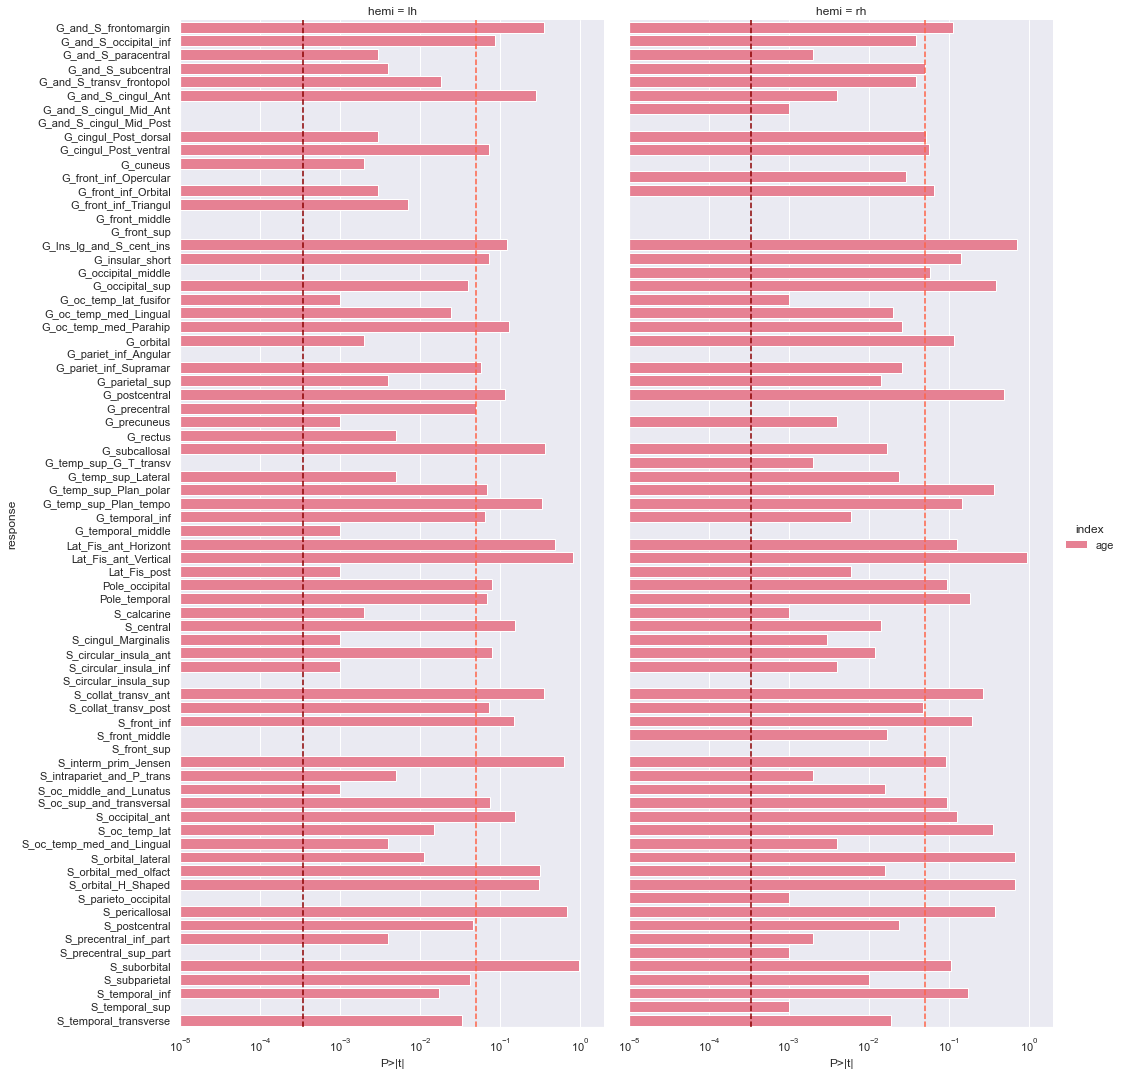

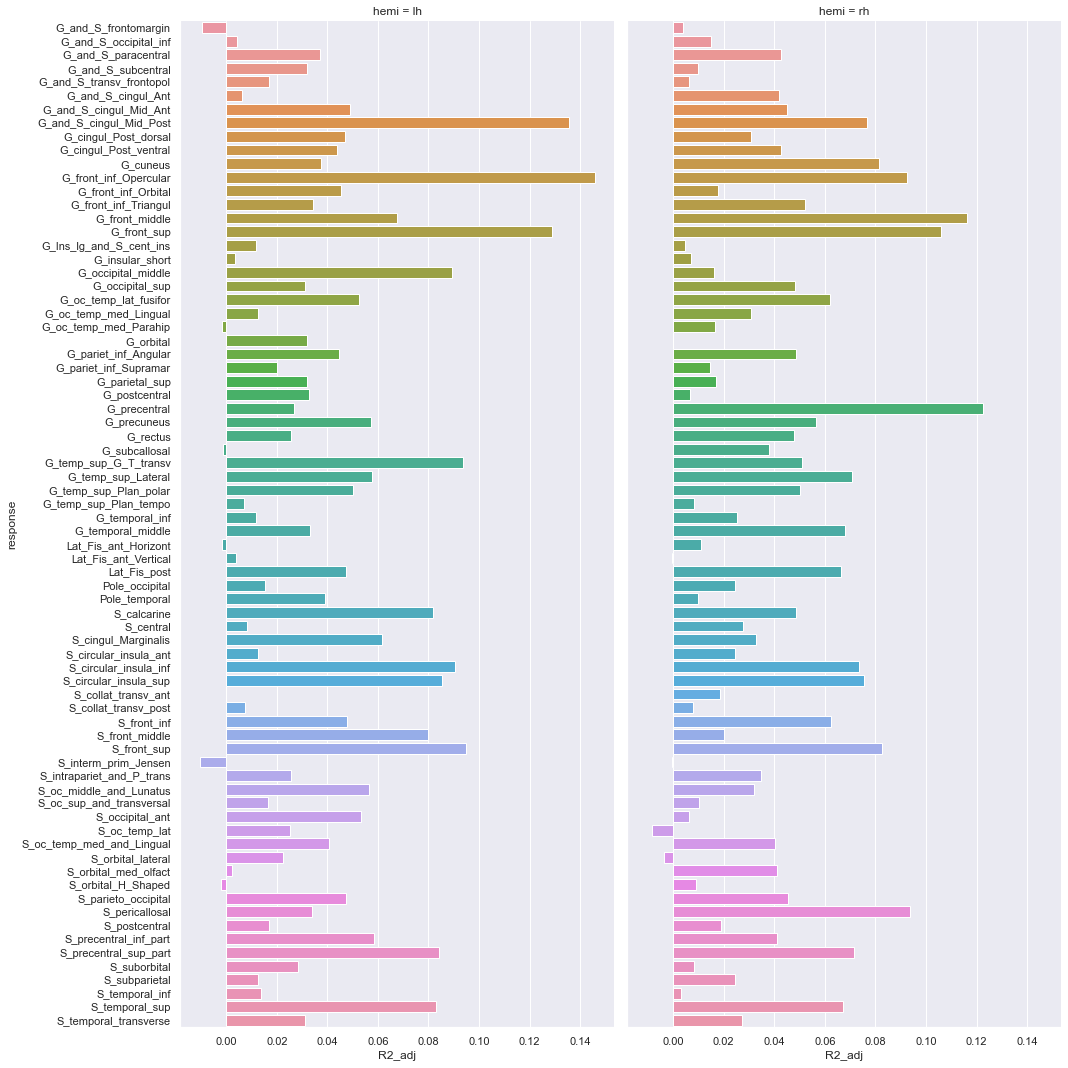

In [43]:
sns.set(font_scale=1)
g = sns.catplot(x='P>|t|', y='response', kind='bar', hue='index', col='hemi',
                aspect=0.5, height=15, palette=sns.color_palette('husl',2), data=all_rois_df)
g.set(xscale='log',xlim=(1e-5,2))
for ax in g.axes.flat:
    ax.axvline(alpha, ls='--',c='tomato')
    ax.axvline(alpha_corr, ls='--',c='darkred')

g = sns.catplot(x='R2_adj', y='response', col='hemi', kind='bar',
                aspect=0.5, height=15, data=all_rois_df)

Finally we can plot the t-scores on a mesh for global brain results visualization.

First we import the Destrieux mesh and labels from nilearn.

In [44]:
from nilearn import datasets

## Nilearn label strings for the Destrieux atlas are slightly different than what FreeSurfer uses.
## Use this function to convert between them.
def map_fs_names_to_nilearn(stat_df, new2old_roinames):
    sign_rois = stat_df[stat_df['P>|t|'] < alpha_corr]['response'].values
    sign_hemis = stat_df[stat_df['P>|t|'] < alpha_corr]['hemi'].values

    nilearn_stats_lh = {}
    nilearn_stats_rh = {}
    for roi, hemi in zip(sign_rois, sign_hemis):
        nilearn_label = new2old_roinames[roi]
        nilearn_label = nilearn_label.replace('&', '_and_')
        #remove hemisphere prefix and thickness suffix from the name
        nilearn_label = nilearn_label.split('_',1)[1].rsplit('_',1)[0]
        t_stat = stat_df[(stat_df['response'] == roi) & (stat_df['hemi'] == hemi)]['t'].values[0]
        if hemi == 'lh':
            nilearn_stats_lh[nilearn_label] = t_stat
        elif hemi == 'rh':
            nilearn_stats_rh[nilearn_label] = t_stat
        else:
            print('unknown hemisphere')
    return nilearn_stats_lh, nilearn_stats_rh

# Retrieve both the Destrieux atlas and labels
destrieux_atlas = datasets.fetch_atlas_surf_destrieux(data_dir='local_data/nilearn_cache')
parcellation = destrieux_atlas['map_left']
labels = destrieux_atlas['labels']
labels = [l.decode('utf-8') for l in labels]
# Retrieve fsaverage5 surface dataset for the plotting background.
fsaverage = datasets.fetch_surf_fsaverage()

In [45]:
### Assign a t-score to each surface atlas ROI
stat_map_lh = np.zeros(parcellation.shape[0], dtype=int)
nilearn_stats_lh, nilearn_stats_rh = map_fs_names_to_nilearn(all_rois_df, new2old_roinames)
# For left hemisphere
for roi, t_stat in nilearn_stats_lh.items():
    stat_labels = np.where(parcellation == labels.index(roi))[0]
    stat_map_lh[stat_labels] = t_stat
# For right hemisphere
stat_map_rh = np.zeros(parcellation.shape[0], dtype=int)
for roi, t_stat in nilearn_stats_rh.items():
    stat_labels = np.where(parcellation == labels.index(roi))[0]
    stat_map_rh[stat_labels] = t_stat

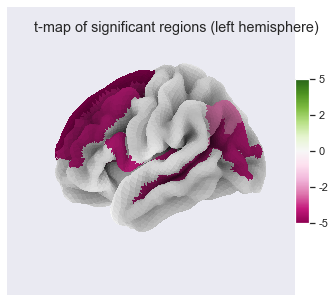

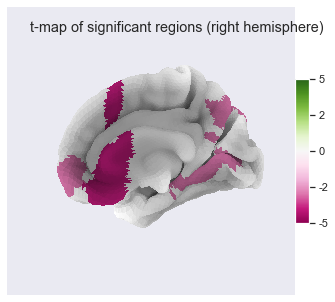

In [46]:
# LATERAL view of the LEFT hemisphere
plotting.plot_surf_roi(fsaverage['pial_left'], roi_map=stat_map_lh,
                       hemi='left', view='lateral', cmap='PiYG', colorbar = True,
                       bg_map=fsaverage['sulc_left'], bg_on_data=True,
                       title='t-map of significant regions (left hemisphere)',
                       vmin=-5, vmax=5);
# MEDIAL view of the RIGHT hemisphere
plotting.plot_surf_roi(fsaverage['pial_right'], roi_map=stat_map_rh,
                       hemi='right', view='medial', cmap='PiYG',  colorbar = True,
                       bg_map=fsaverage['sulc_right'], bg_on_data=True,
                       title='t-map of significant regions (right hemisphere)',
                       vmin=-5, vmax=5);

## Statistical analysis: local GM changes assessed with Voxel Based Morphometry (VBM)

Relying on an atlas to identify and characterize brain changes or/and group differences is a common practice. While it offers more statistical power by limiting the comparisons to a limited set of regions, it introduces bias (the results depend on the choice of atlases) and may miss out on differences limited to a subregion within ROI. Voxel Based Morphometry (VBM) is a technique purely data-driven to detect changes at voxel level.

VBM aims at investigating each voxel independently across a group of subjects. This is a so called mass-univariate analysis: the analysis is done voxel by voxel and then multiple comparison correction is applied. In order to compare a given voxel across subjects, an assumption is that the voxel is at the same position in the subjects’ brain. This assumption is met by registering all maps of interest to a template. The maps investigated are often GM probability maps interpreted as local GM volume (as in this episode).

The comparison requires first a correction for the transformation to the template space (called modulation), and then a mass-univariate statistical approach. We will examine the VBM workflow step by step. We will run the steps on a limited subset of 10 subjects from our 226 subjects cohort in a `subset` directory, while loading the corresponding cohort pre-computed results in the `all_subjects` directory.

### VBM processing

#### Template creation

One answer to the template challenge is to use the probability maps `GM10_probamp_files` created in MNI space by `smriprep/fmriprep` with the `MNI152NLin2009cAsym` template. A simple template can be obtained by averaging all these maps. Note that it is common to create a symmetric by template by average two mirror versions. We are not doing this in this episode.



In [47]:
vbm_dir = 'local_data/AOMIC/derivatives/vbm'
vbm_subset_dir = os.path.join(vbm_dir, "subset")
vbm_cohort_dir = os.path.join(vbm_dir, "all_subjects")

from nilearn.image import concat_imgs, mean_img

GM10_probmap_files = bids_layout.get(scope="derivatives",
                                     space="MNI152NLin2009cAsym",
                                     datatype='anat',
                                     suffix='probseg',
                                     label="GM",
                                     extension='nii.gz',
                                     return_type='filename')

# For demonstration create template for subset
GM10_probmaps_4D_img = concat_imgs(GM10_probmap_files)
GM10_probmap_mean_img = mean_img(GM10_probmaps_4D_img)
GM10_probmap_mean_img.to_filename(os.path.join(vbm_dir, "GM10.nii.gz"))
# For the real application load corresponding template for the cohort
GM226_probmap_mean_img = nib.load(os.path.join(vbm_cohort_dir, "GM226.nii.gz"))


#### Resample to 2-mm template

We will need to register all our subject native probability GM map to the template. The resulting template is 1mm-resolution but computation performance is increased if the template has a lower resolution, and our statistical analysis will require smoothing the data in any case. As a result we will resample the template to 2mm.


In [54]:
from nilearn.datasets import load_mni152_template
from nilearn.image import resample_to_img

# Implementation on a subset of 10 subjects
template = load_mni152_template()
GM10_probmap_mean_img_2mm = resample_to_img(GM10_probmap_mean_img, template)
GM10_probmap_mean_img_2mm.to_filename(os.path.join(vbm_dir, "GM10_2mm.nii.gz"))
# Loading data for the whole cohort
GM226_probmap_mean_img_2mm = nib.load(os.path.join(vbm_cohort_dir, "GM226_2mm.nii.gz"))

0.8.1


We can plot the results to look at the effect of group size and resolution on the templates.

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_12396/3565134606.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar();
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_12396/3565134606.py:24: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar();


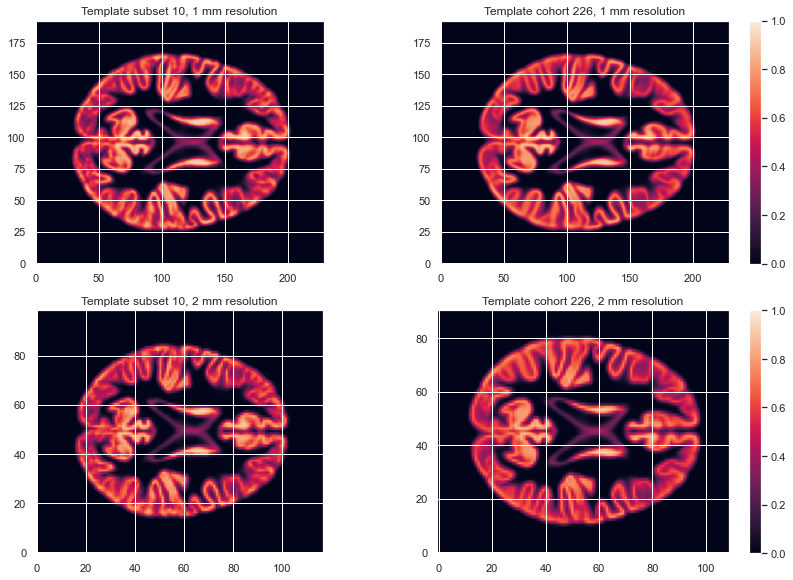

In [55]:
plt.figure(figsize=(12, 16))
n_plots,n_cols  = 4, 2
### Plot 1 mm templates
# Subset 10
plt.subplot(n_plots, n_cols, 1)
plt.imshow(GM10_probmap_mean_img.get_fdata()[:, :, 100], origin="lower", vmin=0, vmax=1)
plt.title('Template subset 10, 1 mm resolution')
# Cohort 256
plt.subplot(n_plots, n_cols, 2)
plt.imshow(GM226_probmap_mean_img.get_fdata()[:, :, 100], origin="lower", vmin=0, vmax=1)
plt.title('Template cohort 226, 1 mm resolution')
plt.colorbar();
### Plot 2 mm templates
# Subset 10
# Plot first figure
plt.subplot(n_plots, n_cols, 3)
plt.imshow(GM10_probmap_mean_img_2mm.get_fdata()[:, :, 47], origin="lower", vmin=0, vmax=1)
plt.title('Template subset 10, 2 mm resolution')
# Cohort 256
# Plot first figure
plt.subplot(n_plots, n_cols, 4)
plt.imshow(GM226_probmap_mean_img_2mm.get_fdata()[:, :, 47], origin="lower", vmin=0, vmax=1)
plt.title('Template cohort 226, 2 mm resolution')
plt.colorbar();
plt.tight_layout() # Magic command to clean the overall plot

### Transformation correction, aka modulation

To compare GM values after transformation to the template space, they need to be modulated. Indeed, if a region in the space the subject expands when transformed to the template space, the intensity values must be corrected to account for the actually smaller original volume. This correction can be performed using the ratio between the template local volume and the corresponding original local volume. The amount of transformation is measured in each voxel by the Jacobian determinant J. So the modulation consists in multiplying or dividing by J according to how it is defined by the transformation software(template volume / local volume, or local volume / template volume).

In our case we run the FSL fnirt non-linear transform utility with the code below.
```
NATIVE_GM_MAPS=(data/derivatives/fmriprep/sub-*/anat/sub-+([0-9])_label-GM_probseg.nii.gz)
for GM_MAP in ${NATIVE_GM_MAPS[@]}; do
    SUBJ_NAME=${GM_MAP%%_label*}
    fsl_reg ${GM_MAP} GM226_2mm.nii.gz \
            data/derivatives/vbm/subset/${SUBJ_NAME}/${SUBJ_NAME}_space-GM226_label-GM_probseg \
            -fnirt "--config=GM_2_MNI152GM_2mm.cnf \
            --jout=data/derivatives/vbm/subset/${SUBJ_NAME}/${SUBJ_NAME}_J"
done
```

For FSL the Jacobian determinant output is less than 1 if the original volume expands when warped to the template, and greater than 1 when it contracts.


In [63]:
GM_native_probmap_files = sorted(glob(os.path.join(fmriprep_dir,
                                                    "sub-000[0-5]",
                                                    "anat",
                                                    "sub-000[0-5]_label-GM_probseg.nii.gz")))

from nilearn.image import math_img, smooth_img

### Implementation on a subset of 10 subjects
subj_dirs = sorted(glob(os.path.join(vbm_subset_dir, "sub-*")))
# Calculating
for subj_dir in subj_dirs:
    subj_name = os.path.basename(subj_dir)
    print(f"==={subj_name}")
    # Get GM probability map in template space
    warped_GM_file = os.path.join(subj_dir, f"{subj_name}_space-GM226_label-GM_probseg.nii.gz")
    warped_GM = nib.load(warped_GM_file)
    # Get scaling factors (trace of Jacobian)
    J_map_file = os.path.join(subj_dir, f"{subj_name}_J.nii.gz")
    J_map = nib.load(J_map_file)
    # Compute modulated map
    modulated_map = math_img("img1 + img2", img1=warped_GM, img2=J_map)
    # Save modulated image
    modulated_map_file = os.path.join(subj_dir, f"{subj_name}_space-GM226_label-GM_mod.nii.gz")
    modulated_map.to_filename(modulated_map_file)


===sub-0001
===sub-0002
===sub-0003
===sub-0004
===sub-0005
===sub-0006
===sub-0007
===sub-0008
===sub-0009
===sub-0010


We can plot all the intermediary steps leading to the modulated maps for two subjects of our cohort.

In [65]:
### 4D merge and mean

## Warped GM maps
warped_10map_files = sorted(glob(os.path.join(vbm_subset_dir, "sub*", "*GM_probseg.nii.gz")))
warped_10maps_4D = concat_imgs(warped_10map_files) # 4D merge
warped_10maps_mean = mean_img(warped_10maps_4D) # Mean
# Save mean
warped_10maps_mean_file = os.path.join(vbm_dir, "subset_space-GM226_label-GM_probseg_mean.nii.gz")
warped_10maps_mean.to_filename(warped_10maps_mean_file)

## Jacobian maps
J_10map_files = sorted(glob(os.path.join(vbm_subset_dir, "sub*", "*J.nii.gz")))
J_10maps_4D = concat_imgs(J_10map_files) # 4D merge
J_10maps_mean = mean_img(J_10maps_4D) # Mean
# Save mean
J_10maps_mean_file = os.path.join(vbm_dir, "subset_space-GM226_label-GM_J_mean.nii.gz")
J_10maps_mean.to_filename(warped_10maps_mean_file)

## Modulated maps
modulated_10map_files = sorted(glob(os.path.join(vbm_subset_dir, "sub*", "*GM_mod.nii.gz")))
modulated_10maps_4D = concat_imgs(modulated_10map_files) # 4D merge
modulated_10maps_mean = mean_img(modulated_10maps_4D) # Mean
# Save 4D maps
modulated_10maps_4D_file = os.path.join(vbm_dir, "subset_space-GM226_label-GM_mod.nii.gz")
modulated_10maps_4D.to_filename(modulated_10maps_4D_file)
# Save mean
modulated_10maps_mean_file = os.path.join(vbm_dir, "subset_space-GM226_label-GM_mod_mean.nii.gz")
modulated_10maps_mean.to_filename(modulated_10maps_mean_file)

In [66]:
# Warped GM maps
warped_226maps_mean_file = os.path.join(vbm_cohort_dir, "cohort_space-GM226_label-GM_probseg_mean.nii.gz")
warped_226maps_mean = nib.load(warped_226maps_mean_file)
# Jacobian maps
J_226maps_mean_file = os.path.join(vbm_cohort_dir, "cohort_space-GM226_label-GM_J_mean.nii.gz")
J_226maps_mean = nib.load(J_226maps_mean_file)
# Modulated maps
modulated_226maps_mean_file = os.path.join(vbm_cohort_dir, "cohort_space-GM226_label-GM_mod_mean.nii.gz")
modulated_226maps_mean = nib.load(modulated_226maps_mean_file)

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_12396/4158816593.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar();
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_12396/4158816593.py:23: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar();


ValueError: Passing parameters norm and vmin/vmax simultaneously is not supported. Please pass vmin/vmax directly to the norm when creating it.

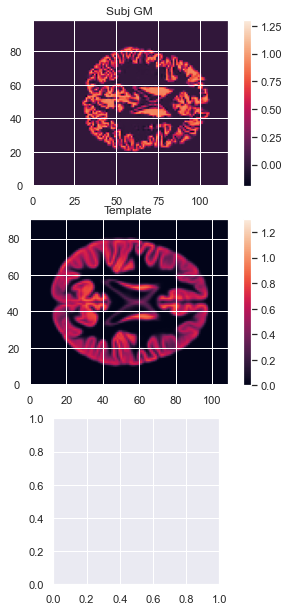

In [68]:
from matplotlib.colors import LogNorm
from matplotlib import ticker

subs = [1, 2]
n_sub = len(subs)
n_plots, n_cols = 5*n_sub, n_sub
i_slice_match = {1: 50, 2: 52}
for i_sub, sub in enumerate(subs):
    ### Original image
    plt.subplot(n_plots, n_cols, (i_sub+1))
    GM_native_probmap_file = GM_native_probmap_files[sub]
    GM_native_probmap = nib.load(GM_native_probmap_file)
    GM_native_probmap_2mm = resample_to_img(GM_native_probmap, template)
    i_slice = i_slice_match[sub]
    plt.imshow(GM_native_probmap_2mm.get_fdata()[:, :, i_slice], origin="lower", vmin=0, vmax=1.3)
    ### Template
    plt.subplot(n_plots, n_cols, (i_sub+1)+1*n_sub)
    plt.imshow(GM226_probmap_mean_img_2mm.get_fdata()[:, :, 47], origin="lower", vmin=0, vmax=1.3)
    plt.title('Template')
    plt.colorbar();
    # Jacobian
    plt.subplot(n_plots, n_cols, (i_sub+1)+2*n_sub)
    log_ticks = np.logspace(-0.4, 0.4, 10)
    plt.imshow(J_10maps_4D.get_fdata()[:, :, 47, sub], origin="lower", norm=LogNorm())
    # Warped image
    plt.subplot(n_plots, n_cols, (i_sub+1)+3*n_sub)
    plt.imshow(warped_10maps_4D.get_fdata()[:, :, 47, sub], origin="lower", vmin=0, vmax=1.3)
    # Subset 10
    plt.subplot(n_plots, n_cols, (i_sub+1)+4*n_sub)
    plt.imshow(modulated_10maps_4D.get_fdata()[:, :, 47, sub], origin="lower", vmin=0, vmax=1.3)

In [ ]:
n_plots, n_cols = 6, 2
### Plot GM warped maps
# Subset 10
plt.subplot(n_plots, n_cols, 1)
plt.imshow(warped_10maps_mean.get_fdata()[:, :, 47], origin="lower", vmin=0, vmax=1)
# Cohort 256
plt.subplot(n_plots, n_cols, 2)
plt.imshow(warped_226maps_mean.get_fdata()[:, :, 47], origin="lower", vmin=0, vmax=1)
### Plot Jacobian maps
# Subset 10
plt.subplot(n_plots, n_cols, 3)
plt.imshow(np.log(J_10maps_mean.get_fdata()[:, :, 47]), origin="lower", vmin=-0.5, vmax=0.5)
# Cohort 256
plt.subplot(n_plots, n_cols, 4)
plt.imshow(np.log(J_226maps_mean.get_fdata()[:, :, 47]), origin="lower", vmin=-0.5, vmax=0.5)
### Plot GM modulated maps
# Subset 10
plt.subplot(n_plots, n_cols, 5)
plt.imshow(modulated_10maps_mean.get_fdata()[:, :, 47], origin="lower", vmin=0, vmax=1)
# Cohort 256
plt.subplot(n_plots, n_cols, 6)
plt.imshow(modulated_226maps_mean.get_fdata()[:, :, 47], origin="lower", vmin=0, vmax=1)

#### Processing: GM mask

To limit our analysis to GM voxels, a GM mask is useful. We can create it according to the mean modulated GM maps (or e.g. mean GM probabilistic maps), and setting a threshold. In our case we choose a modulation value of at least 0.05 in the group average to be included in the analysis.

Now that we have the modulated GM maps all aligned, we can carry out the statistical analysis.

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_12396/3321648292.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar();


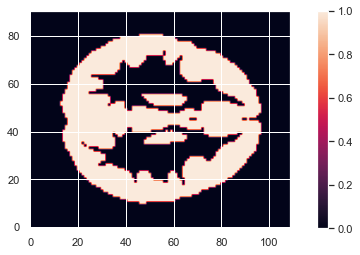

In [71]:
GM_mask = math_img('img > 0.05', img=modulated_226maps_mean)
GM_mask.to_filename(os.path.join(vbm_dir, "GM226_mask.nii.gz"))

plt.figure(figsize=(10, 4))
plt.imshow(GM_mask.get_fdata()[:, :, 50], origin="lower", vmin=0, vmax=1)
plt.colorbar();

### VBM statistical analysis

For the VBM statistical analysis, we implement a two-level GLM model. While it is too long to cover in details in this episode, we can explain it briefly.

####Principles

Consider a single voxel. The GLM model consists in:

1. At subject level, evaluating the beta parameters (aka regression coefficients) in our model. Our model having:
  * Modulated GM as response / predicted variable
  * Age and sex as predictors (with sex as a covariate)
2. At group level, indicating what is the combination of model parameters we want to assess for a significant effect. In our case we just want to look at the age beta parameter value across subjects. It is significantly positive ? Significantly negative ? Not significantly negative or positive ?

#### Design matrix

The first step consists in defining a design matrix, this is a matrix with all our predictors/regressors. In our case this is a column for age, a column for sex, and for an intercept (a constant value).

In [72]:
design_matrix = subjects_info[["participant_id", "age", "sex"]].set_index("participant_id")
design_matrix = pd.get_dummies(design_matrix, columns=["sex"], drop_first=True)
design_matrix["intercept"] = 1
design_matrix

,age,sex_M,intercept
participant_id,,,
sub-0001,25.50,1,1
sub-0002,23.25,0,1
sub-0003,25.00,0,1
sub-0004,20.00,0,1
sub-0005,24.75,1,1
...,...,...,...
sub-0222,22.00,0,1
sub-0223,20.75,0,1
sub-0224,21.75,1,1


In [73]:
dm10 = design_matrix.iloc[:10]
dm10

,age,sex_M,intercept
participant_id,,,
sub-0001,25.50,1,1
sub-0002,23.25,0,1
sub-0003,25.00,0,1
sub-0004,20.00,0,1
sub-0005,24.75,1,1
sub-0006,23.75,1,1
sub-0007,19.25,0,1
sub-0008,21.00,1,1
sub-0009,24.75,0,1


To avoid having noisy data which does not satisfy the GLM statistical criteria (gaussianity of residuals) it is common to smooth the input maps. A smooth operation is included when implement our model next.

### Second level GLM
The second step consists in defining what is the linear combination of `[age_beta_parameter, sex_beta_parameter, intercept]` we want to examine. In our case we want to look only at age, so our linear combination is simply `1 * age_parameter + 0 * sex_parameter + 0 * intercept`. This is defined by what is called a contrast, which is then `[1, 0, 0]` in our case.

These two steps can be implemented with the `SecondLevelModel` python object of the nilearn glm module. We can use the `fit` method of a `SecondLevelModel` object on a design matrix to compute all the beta parameters for each subject. Then we can call the `compute_contrast` method with our contrast to assess if GM local volume is significantly associated with age.

For our subset of subjects the corresponding Python code is as follows:


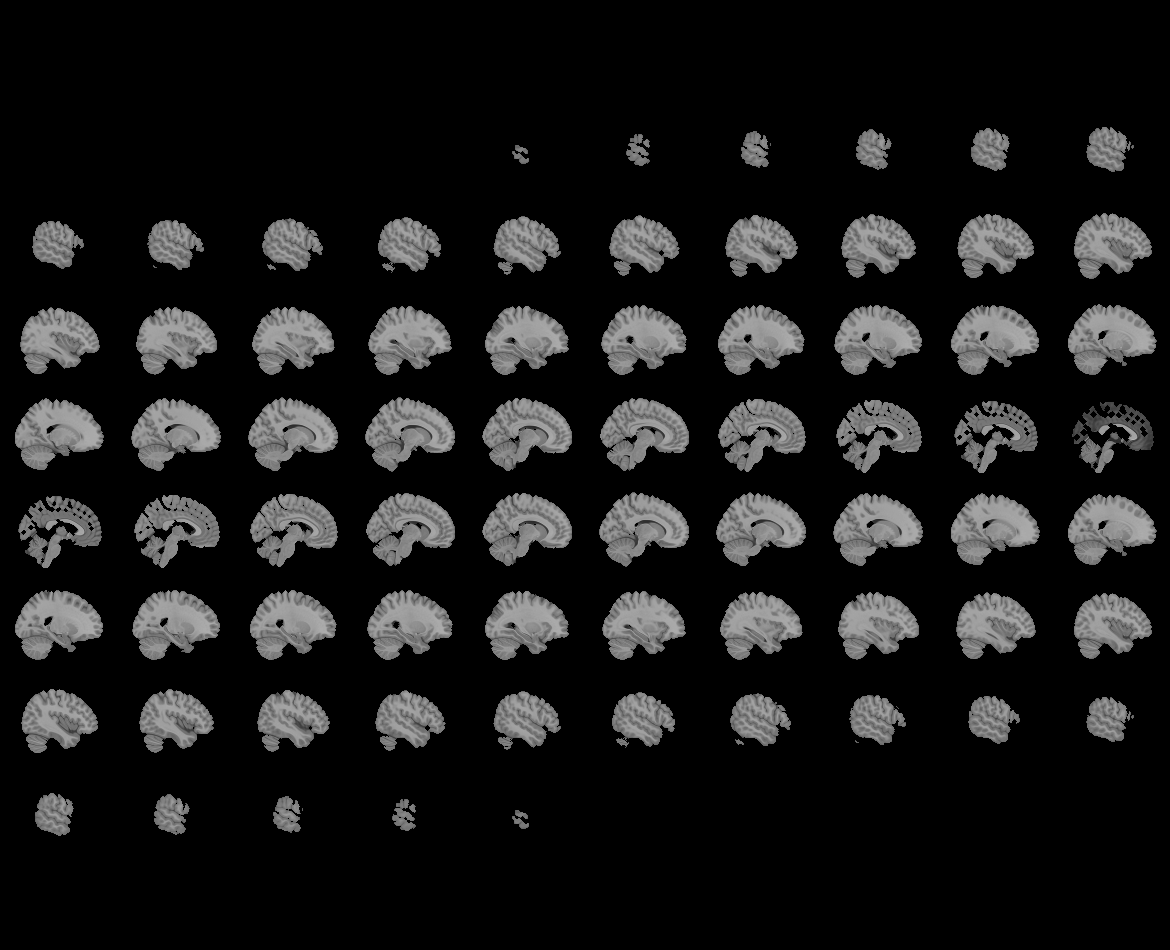
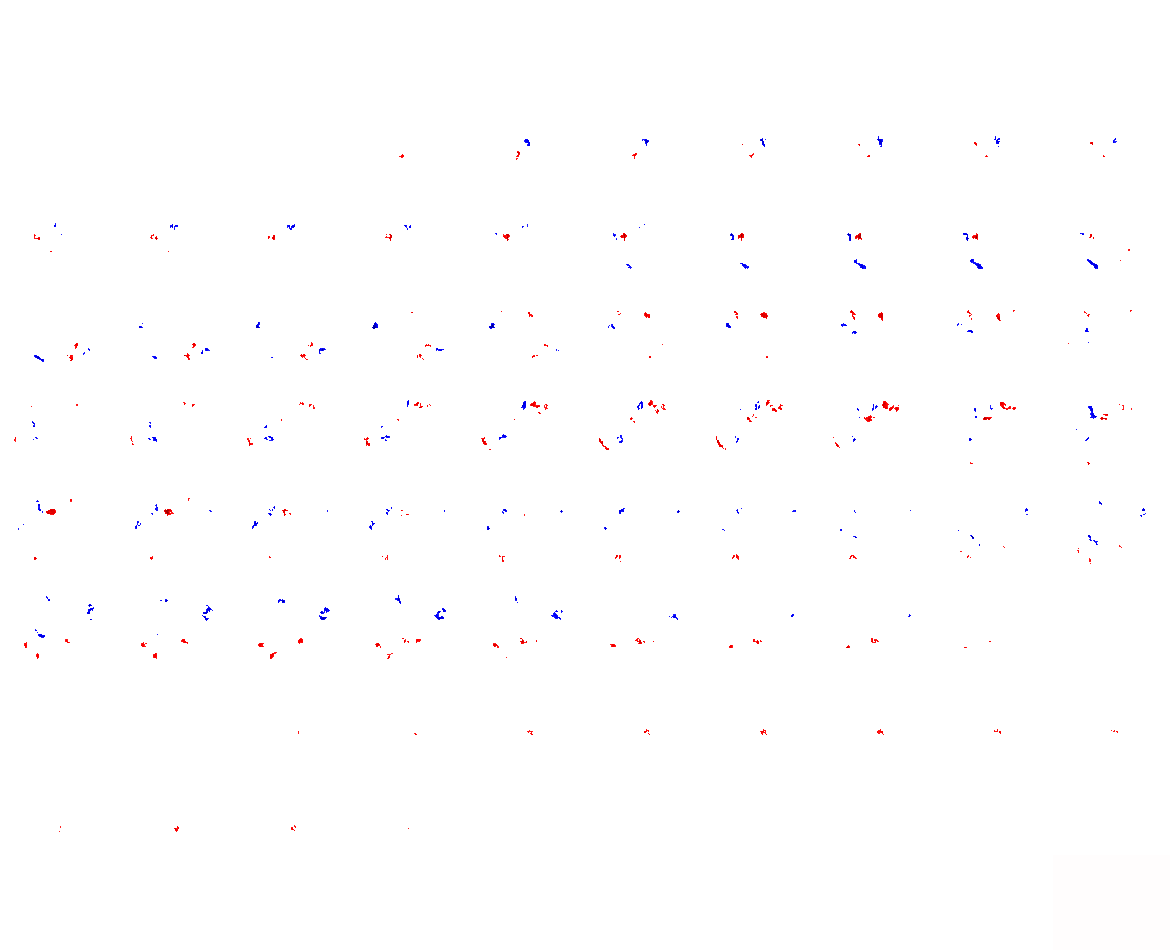

In [75]:
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.reporting import make_glm_report
from nilearn.plotting import plot_stat_map

level2_glm10 = SecondLevelModel(smoothing_fwhm=3.0, mask_img=GM_mask)
level2_glm10.fit(modulated_10map_files, design_matrix=dm10)

zmap10 = level2_glm10.compute_contrast(second_level_contrast=[1, 0, 0], output_type='z_score')
# For the subset of subjects

zmap10_thr, z10thr = threshold_stats_img(zmap10,
                                         mask_img=GM_mask,
                                         alpha=.05,
                                       height_control='fpr',
                                         cluster_threshold=50)

plotting.view_img(zmap10_thr, threshold=z10thr, cmap="seismic")


Finally, do not forget we are looking at a massive collection of voxels. Because we carry out so many statistical tests (one for each voxel), it is crucial we correct for multiple comparison. We can do so with `nilearn.threshold_stats_img function`.

Loading data for the whole cohort



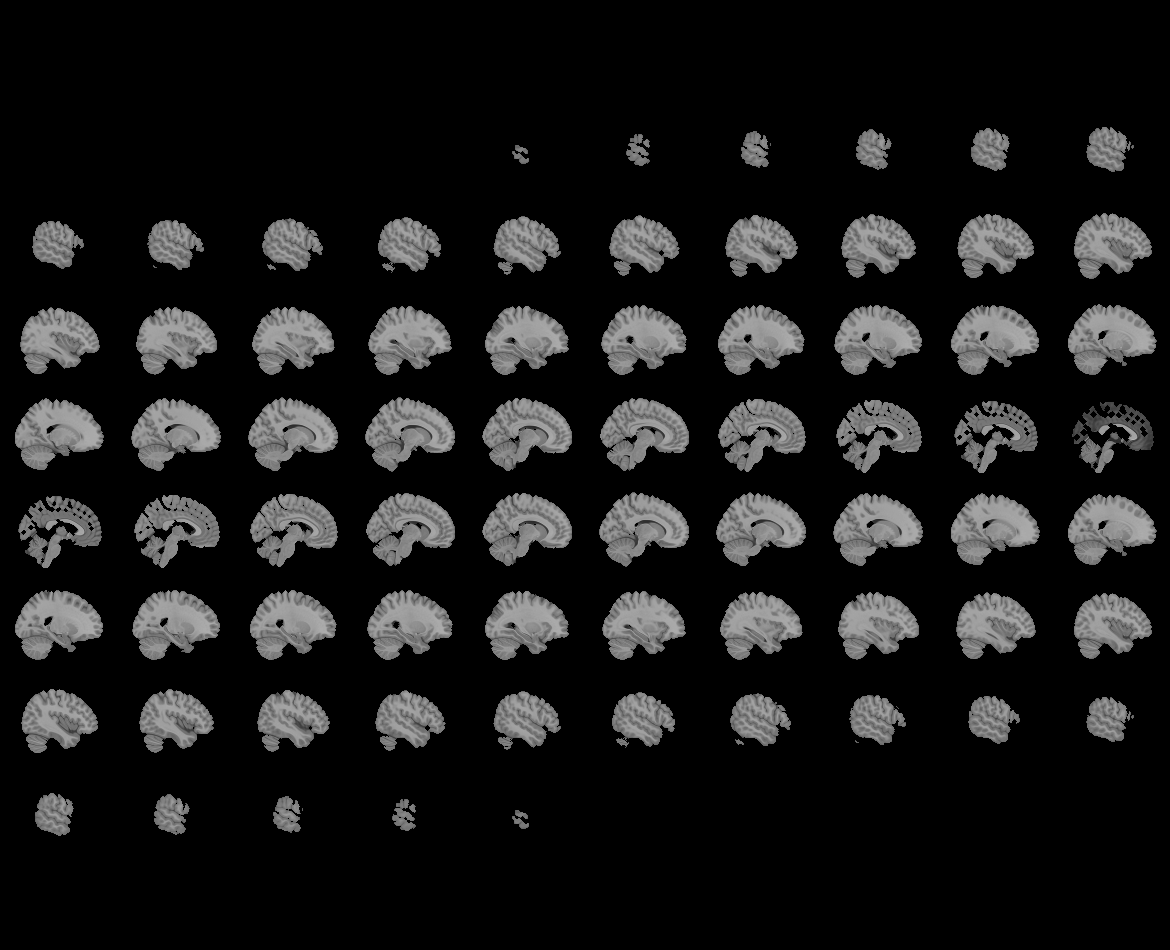
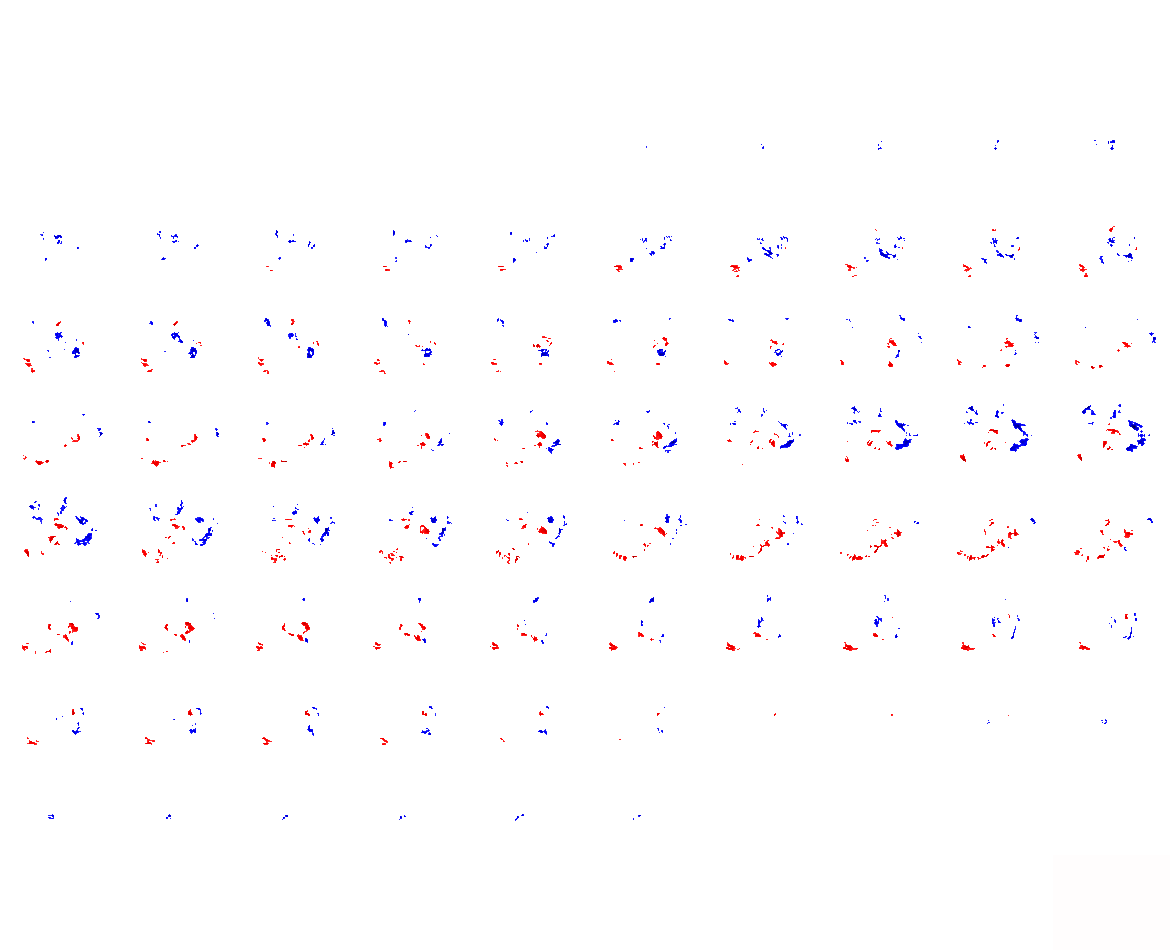

In [77]:
zmap226_file = os.path.join(vbm_dir, "zmap_raw_GM226_age.nii.gz")
zmap226 = nib.load(zmap226_file)

zmap226_thr, z226thr = threshold_stats_img(zmap226, mask_img=GM_mask, alpha=.05,
                                        height_control='fpr', cluster_threshold=50)

plotting.view_img(zmap226_thr, threshold=z226thr, cmap="seismic")
